In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 8.2 The dataset
#### a) Load the dataset and inspect the first element

In [ ]:
data_flat = np.loadtxt('pos_e1_e2_e3_1000.txt')
data_flat[0]

array([  5.055,   4.292,   4.101,   2.267,   4.693,   5.854,   4.157,
         7.436,   4.909,   6.814,   5.613,   6.151,   6.329,   5.469,
         6.029,   4.513,   5.389,   5.204,   6.683,   3.808,   3.957,
         6.478,   3.79 ,   5.511, -34.298, -32.365, -33.88 ])

In [3]:
data_in_file = [[d[:24].reshape(12,2),d[24],d[25],d[26]] for d in data_flat]
data_in_file[0]

[array([[5.055, 4.292],
        [4.101, 2.267],
        [4.693, 5.854],
        [4.157, 7.436],
        [4.909, 6.814],
        [5.613, 6.151],
        [6.329, 5.469],
        [6.029, 4.513],
        [5.389, 5.204],
        [6.683, 3.808],
        [3.957, 6.478],
        [3.79 , 5.511]]),
 -34.298077,
 -32.365418,
 -33.880081]

#### b) Make sure you handle the data correctly by plotting it

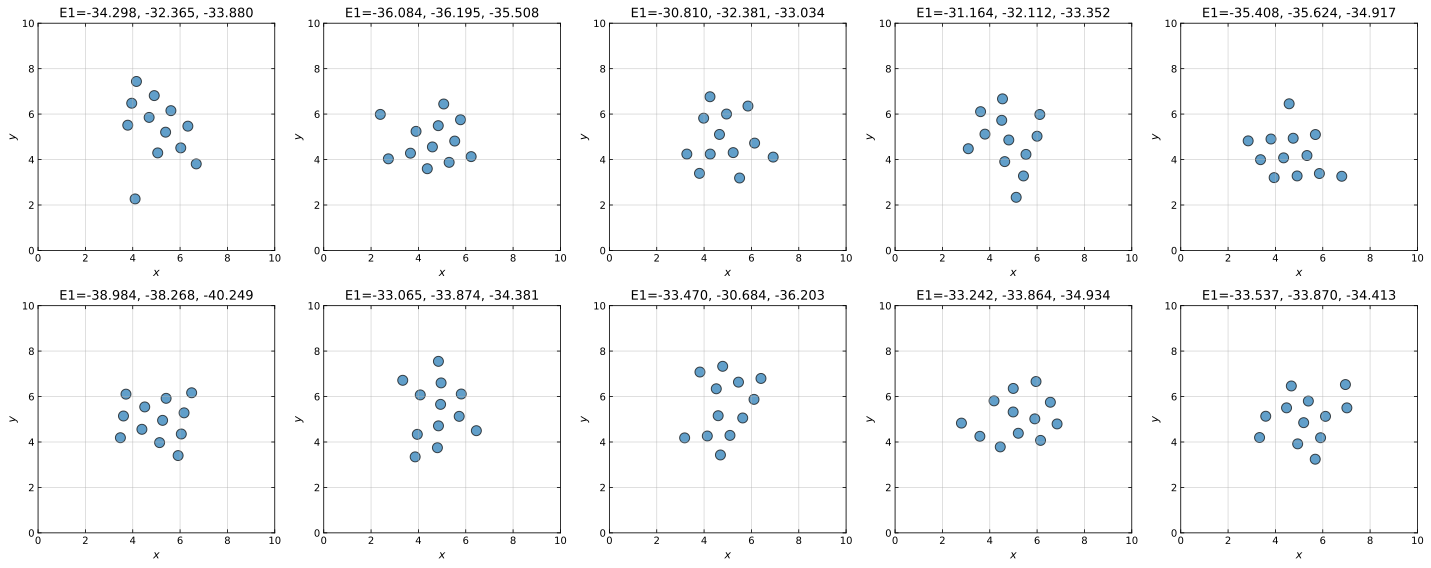

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Iterate over axes and the first 10 atomic clusters
for ax, (pos, energy1, energy2, energy3) in zip(axes.ravel(), data_in_file[:10]):
    # Plot the atomic positions as scatter points
    ax.scatter(*pos.T, c='C0', edgecolor='k', s=100, alpha=0.7)
    
    # Titles showing energy values
    ax.set_title(f'E1={energy1:.3f}, {energy2:.3f}, {energy3:.3f}')
    
    # Format axes
    ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=[0,10], ylim=[0,10])
    ax.grid(alpha=0.5)

# Overall layout adjustments
plt.tight_layout()

fig.savefig('ex54_fig1.png')

If you are interested, you can plot the energy labels versus each other to see that there are some non-trivial differences between them

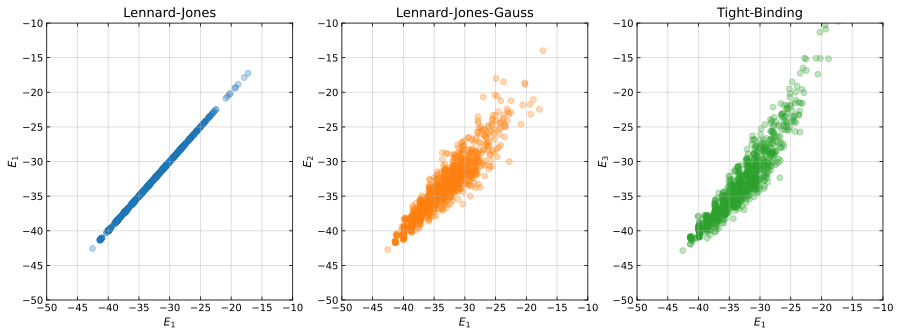

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Extract E1, E2, and E3 values from the data
energies = [
    np.array([data[1] for data in data_in_file]),  # E1
    np.array([data[2] for data in data_in_file]),  # E2
    np.array([data[3] for data in data_in_file])   # E3
]

titles = ["Lennard-Jones", "Lennard-Jones-Gauss", "Tight-Binding"]
colors = ['C0', 'C1', 'C2']

# Nested loop for plotting
for i, ax in enumerate(axes):
    ax.scatter(energies[0], energies[i], c=colors[i], alpha=0.3)
    ax.set_title(titles[i])
    ax.set(xlabel=r"$E_1$", ylabel=fr"$E_{i+1}$", xlim=[-50,-10], ylim=[-50,-10])  # Labels adapt to energy index
    ax.grid(alpha=0.5)

fig.savefig('ex54_fig2.png')

### 8.3 Wrap the data
In order to use the data in conjunction with PyTorch `torch.nn.Module` models, it is convenient to wrap them as `Dataset`s and have them fed by `DataLoader`s.

c) Complete this code to achieve that. The `ENERGY_LABEL` parameter decides which of the three energies associated with each atomic cluster structure is used. We start by using the first energy label.

In [6]:
from torch.utils.data import Dataset, DataLoader

class ClusterDataset(Dataset):
    def __init__(self, data_from_file, label_index=1):
        self.data = torch.tensor(np.array([data[0] for data in data_from_file]), dtype=torch.float32)
        self.labels = torch.tensor(np.array([data[label_index] for data in data_from_file]), dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [7]:
ENERGY_LABEL = 1
# Divide training, validation, and test data in 80%, 10%, 10% proportions
# Total number of clusters
n = data_flat.shape[0]

# Shuffle indices
indices = torch.randperm(n)

# Define split sizes
n_train = int(0.8 * n)
n_val = int(0.1 * n)

# Split indices
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Split data
dataset_train = ClusterDataset([data_in_file[i] for i in train_indices], label_index=ENERGY_LABEL)
dataset_val = ClusterDataset([data_in_file[i] for i in val_indices], label_index=ENERGY_LABEL)
dataset_test = ClusterDataset([data_in_file[i] for i in test_indices], label_index=ENERGY_LABEL)

# Create DataLoaders
dataloader_train = DataLoader(dataset=dataset_train, batch_size=128, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=128, shuffle=False)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=128, shuffle=False)

# Print the number of clusters in each set
print(len(dataset_train), len(dataset_val), len(dataset_test))
print(len(dataloader_train), len(dataloader_val), len(dataloader_test))

800 100 100
7 1 1


### 8.4 Fit with Lennard-Jones-Gauss

In [8]:
class LennardJonesGauss(nn.Module):
    def __init__(self, eps=0.5, sigma_squared=0.03, r0=1.6, eInf=0.1, A=0.9):
        super().__init__()
        self.eps = torch.nn.Parameter(torch.tensor(float(eps)))
        self.sigma_squared = torch.nn.Parameter(torch.tensor(float(sigma_squared)))
        self.r0 = torch.nn.Parameter(torch.tensor(float(r0)))
        self.eInf = torch.nn.Parameter(torch.tensor(float(eInf)))
        self.A = torch.nn.Parameter(torch.tensor(float(A)))
    
    def V(self, r):
        return self.A * (r**-12 - 2*r**-6 - self.eps*torch.exp(-(r-self.r0)**2/(2*self.sigma_squared))) + self.eInf
    
    def forward(self, coords):
        # Directly compute pairwise distances for each atomic cluster in the batch
        pairwise_distances = torch.stack([torch.pdist(batch) for batch in coords])

        # Calculate the total energy for each cluster
        energies = torch.stack([self.V(dists).sum() for dists in pairwise_distances])

        return energies


class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

Optimize the parameters of the model so as to minimize the error when predicting the energy of the atomic clusters with the model

In [9]:
# Training loop
def train_model(model, dataloader_train, dataloader_val, optimizer, loss_fn, early_stopping=None, epochs=100):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        train_loss = 0.0

        for coords, energy_labels in dataloader_train:
            optimizer.zero_grad()

            # Forward pass: Predict energies for clusters
            predicted_energies = model(coords)
            
            # Compute loss
            loss = loss_fn(predicted_energies, energy_labels)
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * coords.size(0)
        
        train_loss /= len(dataloader_train.dataset)
        train_losses.append(train_loss)

        # Validation Step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for coords, energy_labels in dataloader_val:
                predicted_energies = model(coords)
                loss = loss_fn(predicted_energies, energy_labels)
                val_loss += loss.item() * coords.size(0)
        
        val_loss /= len(dataloader_val.dataset)
        val_losses.append(val_loss)

        # Early stopping
        if early_stopping is not None:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

    return train_losses, val_losses, model

Training:  83%|████████▎ | 622/750 [03:03<00:37,  3.38it/s]

Early stopping triggered at epoch 623


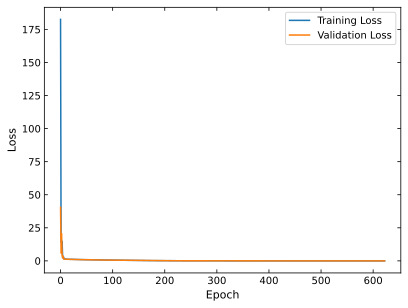

In [10]:
# Initialize the model
model = LennardJonesGauss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
early_stopping = EarlyStopping(patience=5)

# Train the model
train_losses, val_losses, trained_model = train_model(
    model, dataloader_train, dataloader_val, optimizer, loss_fn, early_stopping, epochs=750
)

# Plot the training and validation losses
fig, ax = plt.subplots()
ax.plot(train_losses, label="Training Loss")
ax.plot(val_losses, label="Validation Loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()

fig.savefig('ex54_fig3.png')

[(-2.0, 2.0)]

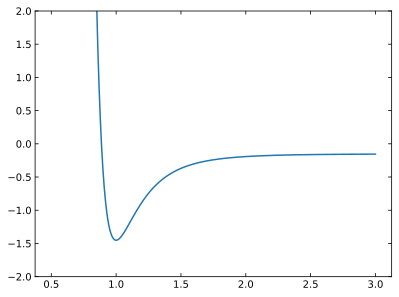

In [11]:
rs = torch.linspace(0.5, 3.0, 1000)
V = trained_model.V(rs)
fig, ax = plt.subplots()
ax.plot(rs, V.detach().numpy())
ax.set(ylim=[-2,2])